In [1]:
import obspy, glob
import numpy as np
from obspy import Trace, UTCDateTime
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
# import h5py
import matplotlib.dates as mdates
from matplotlib import cm
from datetime import datetime, date, timedelta
from scipy import signal
import numpy.matlib
from scipy.signal import hilbert
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/Volumes/Data/Soundscape/07_Tainan/G1/20231108-20231115/wav'

S = -174.7 # end to end 
P_ref = 1 # water: 1 uPa
interval = 1 # min

In [10]:
def calib(data, S):
    audio_data = data.astype(np.float32, order='C') / 32768.0
    calib_data = audio_data / ((10)**(S/20))
    return calib_data # uPa

def SPL(tr):
    data = tr.data
    P_ref = 1
    dp = int(0.002*48000) # ms*rate 
    findpeak = [] 
    spl_p2p = []
    cont_score = []
    
    from scipy.signal import find_peaks
    peaks, _  = find_peaks(data, prominence=1, distance=32, wlen=96, height = 1.778*10**6) ## SPLpp=125
    for max_idx in peaks:
        if max_idx>48:
            data_ = data[max_idx-48:max_idx+48]
            # if len(data_) != 96:
            #     print(max_idx, len(data_))
            p_peak = max(data_)+abs(min(data_))
            P_spl = 20*np.log10(p_peak/P_ref)

            envelope = []
            for i in range(0, len(data_), 6):
                env_ = np.abs((hilbert(data_[i:i+6])))
                for x in env_:
                    envelope.append(x)    
            k_data = smooth(envelope)
            score = detection(k_data, envelope)
            cont_score.append(score)
            if score >= 0.75 and P_spl >= 125:
                findpeak.append((max_idx))
                spl_p2p.append(P_spl)
#             if score >= 0.9:
#                 plt.figure(figsize=(3,4))
#                 plt.subplot(211)

#                 # print(k_data)
#                 # plt.plot(np.linspace(0, 0.002, dp)*1000, k_data, 'b', lw=3)
#                 # plt.plot(np.linspace(0, 0.002, dp)*1000, envelope, 'r', lw=1)
#                 plt.plot(np.linspace(0, 0.002, dp)*1000, data_ , 'k', lw=1)
#                 plt.xlim(0, 2)
#                 plt.ylabel('Amplitude [uPa]')
#                 plt.subplot(212)
#                 f, t, spectro = spectrogram(data_)
#                 plt.imshow(spectro, vmin=40, vmax=70,
#                            origin='lower',  aspect='auto', cmap=cm.jet,
#                            extent=[0, 2, f[0]/1000, f[-1]/1000], interpolation='none')
#                 plt.ylabel('Frequency [kHz]')
#                 plt.xlabel('Time [ms]')  
#                 plt.suptitle(f'{round(P_spl,2), round(score,2)}')
#                 # print( P_spl,score,)
            
                       
    return findpeak, peaks, cont_score, spl_p2p
        
            
            
def spectrogram(data, length=16):
    f,t,P = signal.stft(data, fs= 48000, window='hann', 
            nperseg=length, noverlap=int(0.9*length), detrend='constant', boundary=None, padded=False)
    data = 10*np.log10(np.abs(P)/np.power(1, 2))

    return f, t, data

def smooth(x ):
    from scipy.ndimage.filters import gaussian_filter1d
    # filterdData = gaussian_filter1d(x, 3)
    from scipy.signal import savgol_filter
    filterdData = savgol_filter(x, 9, 5, mode='nearest')
    # from scipy.signal import medfilt
    # from scipy.ndimage import median_filter
    # filterdData = medfilt(x, kernel_size=3)
    filterdData[:20] = 0
    filterdData[20:] = filterdData[20:]/2
    filterdData = gaussian_filter1d(filterdData, 2)
    # filterdData = median_filter(x, size=9, mode='constant')
    
    return filterdData
def detection(kernel, envelope):
    np_score = np.corrcoef(kernel, envelope)
    score = np_score[0][1]
    return score

In [28]:
df_min = {'Time':[],
         'Peak': [],
         'MaxSPL': [], 
         'SPLrms':[]}
for file in glob.glob(f'{path}/7206.231111190001.wav'):
    print(file)
    rate, data_ = read(file) 
    data = calib(data_, S)
    
    filetime = file.rsplit('.')[1]
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    if rate == 96000:
        tr.decimate(2, no_filter=True)
    
    tr.stats.starttime = UTCDateTime(2023, int(filetime[2:4]), int(filetime[4:6]), int(filetime[6:8]), int(filetime[8:10]), int(filetime[10:]))
    tr_bp = tr.copy()
    tr_bp.filter('bandpass',freqmin=3000, freqmax=10000,  corners=6, zerophase=True)#'highpass', freq=1000, corners=6, zerophase=True)
    
    total_min = int(tr.stats.endtime - tr.stats.starttime)/60
    

    for mm in range(int(total_min)):
        print(mm)
        df_sec = {'Time':[],
                 'Peak': [],
                 'MaxSPL': []}
        
        tr_cut = tr_bp.copy()
        start = tr.stats.starttime + mm*60 
        end = start + 60
        tr_cut = tr_cut.slice(starttime=start, endtime=end)
        
        p_rms = np.sqrt(np.mean(tr_cut.data**2))
        P_spl = 20*np.log10(p_rms/P_ref)
        
        for ss in range(60):
            tr_cut = tr_bp.copy()
            start = tr.stats.starttime + mm*60 + ss
            end = start + 1 
            tr_cut = tr_cut.slice(starttime=start, endtime=end)

            findpeak, all_score, cont_score, SPL_p2p = SPL(tr_cut)
            df_sec['Time'].append(tr_cut.stats.starttime)
            value = len(findpeak)  if len(findpeak)>0 else np.nan
            df_sec['Peak'].append(value)
            value = max(SPL_p2p)  if len(SPL_p2p)>0 else np.nan
            df_sec['MaxSPL'].append(value)
            
        tr_time = tr_cut.stats.starttime
        df_min['Time'].append(UTCDateTime(tr_time.year, tr_time.month, tr_time.day, tr_time.hour, tr_time.minute))
        df_min['Peak'].append(np.nansum(df_sec['Peak']))
        df_min['MaxSPL'].append(np.nanmax(df_sec['MaxSPL']))
        df_min['SPLrms'].append(P_spl)
    
# df_min = pd.DataFrame(df_min)
        

/Volumes/Data/Soundscape/07_Tainan/G1/20231108-20231115/wav/7206.231111190001.wav
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


In [30]:
df_min = pd.DataFrame(df_min)
df_min

,Time,Peak,MaxSPL,SPLrms
0,2023-11-11T19:01:00.000000Z,312.0,148.028432,103.987994
1,2023-11-11T19:02:00.000000Z,277.0,145.433898,103.851262
2,2023-11-11T19:03:00.000000Z,342.0,148.615271,104.861082
3,2023-11-11T19:04:00.000000Z,340.0,149.388148,104.797204
4,2023-11-11T19:05:00.000000Z,302.0,151.359800,104.523703
5,2023-11-11T19:06:00.000000Z,294.0,146.901055,104.001930
6,2023-11-11T19:07:00.000000Z,286.0,151.128342,103.949909
7,2023-11-11T19:08:00.000000Z,318.0,148.004483,104.214910
8,2023-11-11T19:09:00.000000Z,306.0,150.303343,104.403260
9,2023-11-11T19:10:00.000000Z,388.0,151.562866,105.106766


## for plotting 

calculating spectrogram ......
find peak ........
plot peak ........
3


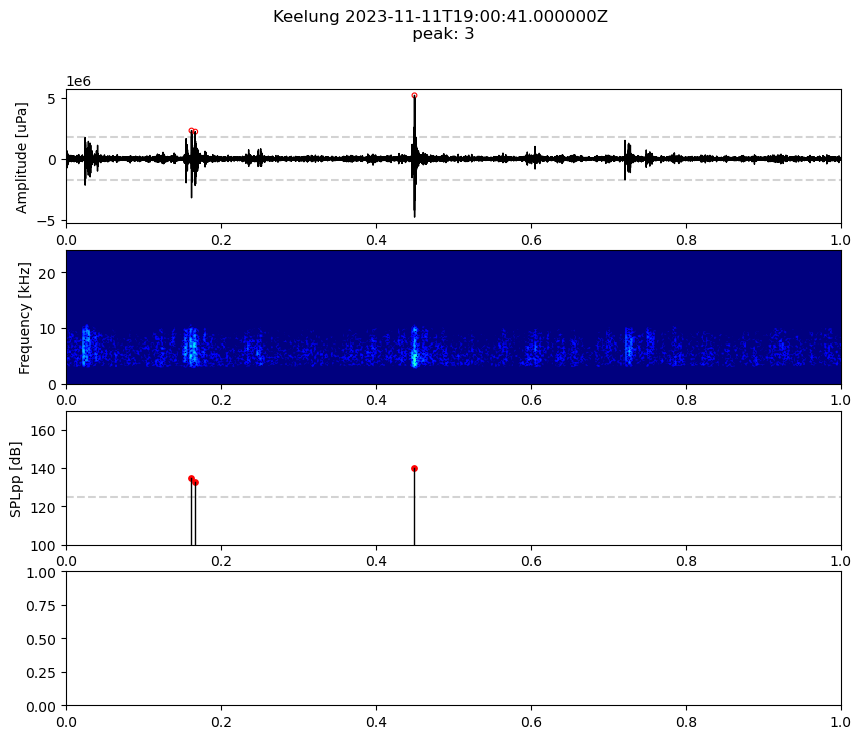

In [33]:
df = {'Time':[],
     'Peak': [],
     'MaxSPL': []}
plot = True
total_sec = int(tr_bp.stats.endtime - tr_bp.stats.starttime)
for dt in np.arange(40, 41, interval):
    tr_cut = tr_bp.copy()
    start  = tr_bp.stats.starttime + dt
    end    = start+1
    tr_cut = tr_cut.slice(starttime=start, endtime=end)
    
    findpeak, all_peaks, all_score, SPL_p2p = SPL(tr_cut)
    
    df['Time'].append(tr_cut.stats.starttime)
    df['Peak'].append(len(findpeak))
    df['MaxSPL'].append(max(SPL_p2p) if len(findpeak) >0 else np.nan)
    
    if plot:
        fig, ax = plt.subplots(4, 1, figsize=(10,8))
        ax[0].hlines(xmin=tr_cut.times()[0], xmax=tr_cut.times()[-1], y=1.778*10**6, color='lightgrey', ls='--')
        ax[0].hlines(xmin=tr_cut.times()[0], xmax=tr_cut.times()[-1], y=-1.778*10**6, color='lightgrey', ls='--')
        
        ax[0].plot(tr_cut.times(), tr_cut.data, 'k', lw=1)
        ax[0].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])
        ax[0].set_ylabel('Amplitude [uPa]')

        f, t, data_1min = spectrogram(tr_cut.data, length=512/2)
        print('calculating spectrogram ......')
        ax[1].imshow(data_1min, vmin=40, vmax=80,
                               origin='lower',  aspect='auto', cmap=cm.jet,
                               extent=[0, 1, f[0]/1000, f[-1]/1000], interpolation='none')
        ax[1].set_ylabel('Frequency [kHz]')

        print('find peak ........')

        ax[2].hlines(xmin=tr_cut.times()[0], xmax=tr_cut.times()[-1], y=125, color='lightgrey', ls='--')
        # ax[3].hlines(xmin=0, xmax=tr_cut.data.shape[0], y=0.75, color='lightgrey', ls='--')
        # ax[3].scatter(all_peaks, all_score, marker = 'o', s= 15,color='black')
        # # ax[2].scatter(range(0,tr_cut.data.shape[0], int(0.002*48000)), all_score, marker = 'o', s= 10, color='black')
        # ax[3].set_ylim(0.4,1)
        # ax[3].set_xlim(0,tr_cut.data.shape[0])
        # ax[3].set_xticks(ticks=range(0,tr_cut.data.shape[0], int(0.2*48000)), labels=[0, 0.2,0.4,0.6,0.8,1.0])
        # ax[3].set_ylabel('Coeff.')
        ax[1].set_xlabel('Time [s]')
        # ax[2].set_xticks(range(0,tr_cut.data.shape[0], int(0.002*48000)), labels=)
        print('plot peak ........')

        for i, idx in enumerate(findpeak):
            corr_time = 0 + idx/48000
            corr_y = tr_cut.data[idx]
            ax[0].scatter(corr_time,corr_y, marker = 'o', s= 12, color='none', linewidths=0.8, edgecolor='red' )
            ax[2].plot([corr_time,corr_time], [100,SPL_p2p[i]], c='k', linewidth=1 )
            ax[2].scatter(corr_time,SPL_p2p[i], marker = 'o', s= 15, color='red', linewidths=1, edgecolor='red' )
        print(len(findpeak))
        ax[2].set_ylim(100, 170)
        ax[2].set_ylabel('SPLpp [dB]')
        ax[2].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])

        plt.suptitle(f'Keelung {start}\n peak: {len(findpeak)}')

# df = pd.DataFrame(df)
# df.to_csv()

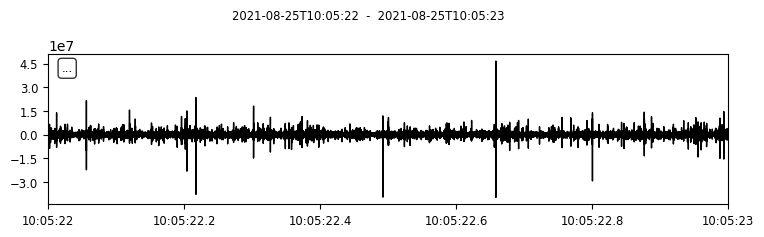

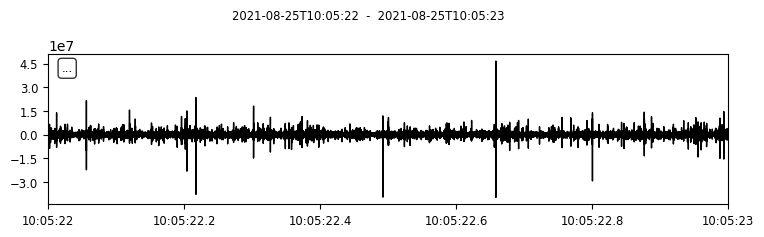

In [7]:
tr_cut

In [13]:
write(f'qqq.wav', int(tr_cut.stats.sampling_rate), np.int16(tr_cut.data/np.max(np.abs(tr_cut.data)) * 32767))
# write(f'qqq_lp.wav', int(tr_cut_lp.stats.sampling_rate/2), np.int16(tr_cut_lp.data/np.max(np.abs(tr_cut_lp.data)) * 32767))




In [1]:
100*24*20 #MB/hr

48000

In [ ]:
48000/